# CNN Project
For this project I used the <a href='https://www.kaggle.com/zalando-research/fashionmnist'>Fashion-MNIST</a> dataset, also available through <a href='https://pytorch.org/docs/stable/torchvision/index.html'><tt><strong>torchvision</strong></tt></a>. This dataset consists of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes:
0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot


## Standard imports, load the Fashion-MNIST dataset
PyTorch makes the Fashion-MNIST dataset available through <a href='https://pytorch.org/docs/stable/torchvision/datasets.html#fashion-mnist'><tt><strong>torchvision</strong></tt></a>. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

transform = transforms.ToTensor()

train_data = datasets.FashionMNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='../Data', train=False, download=True, transform=transform)

class_names = ['T-shirt','Trouser','Sweater','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Boot']

In [2]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [3]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

## 1. Create data loaders
Use DataLoader to create a <tt>train_loader</tt> and a <tt>test_loader</tt>. Batch sizes should be 10 for both.

In [4]:

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)



## 2. Examine a batch of images
With DataLoader, <tt>make_grid</tt> and matplotlib I'll display the first batch of 10 images and their corresponding labels.<br>

Label: [    0     2     4     8     7     3     6     1     0     5]
Class:  T-shirt Sweater Coat Bag Sneaker Dress Shirt Trouser T-shirt Sandal


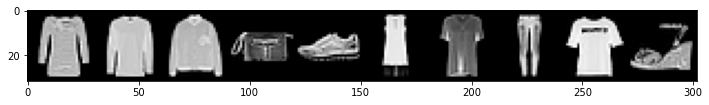

In [6]:

np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=10)  # the default nrow is 8
plt.figure(figsize=(12,6))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Downsampling
<h3>3. If a 28x28 image is passed through a Convolutional layer using a 5x5 filter, a step size of 1, and no padding, what is the resulting matrix size?</h3>

<div style='border:1px black solid; padding:5px'>
<br><br>
</div>

In [9]:

conv = nn.Conv2d(1, 1, 5, 1)
for x,labels in train_loader:
    print('Orig size:',x.shape)
    break
x = conv(x)
print('Down size:',x.shape)

Orig size: torch.Size([10, 1, 28, 28])
Down size: torch.Size([10, 1, 24, 24])


### 4. When the sample from 3 is then passed through a 2x2 MaxPooling layer, what is the resulting matrix size?

<div style='border:1px black solid; padding:5px'>
<br><br>
</div>

In [10]:

x = F.max_pool2d(x, 2, 2)
print('Down size:',x.shape)

Down size: torch.Size([10, 1, 12, 12])


## CNN definition
### 5. A convolutional neural network
A CNN model that can be trained on the Fashion-MNIST dataset.

In [11]:

class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 100) 
        self.fc2 = nn.Linear(100, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)  
    
torch.manual_seed(101)
model = ConvolutionalNetwork()

## Trainable parameters

### 6. Total number of trainable parameters (weights & biases) in the model


<div style='border:1px black solid; padding:5px'>
<br><br>
</div>

In [12]:
# CODE HERE
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

    54
     6
   864
    16
 40000
   100
  1000
    10
______
 42050


### 7. Define loss function & optimizer


In [13]:
# CODE HERE
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


### 8. Train the model


In [15]:
# CODE HERE
import time
start_time = time.time()

epochs = 5

for i in range(epochs):
    for X_train, y_train in train_loader:

        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred,y_train)

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'{i+1} of {epochs} epochs completed')


duration = time.time() - start_time 
print(f'Duration: {duration / 60} minutes ')


1 of 5 epochs completed
2 of 5 epochs completed
3 of 5 epochs completed
4 of 5 epochs completed
5 of 5 epochs completed
Duration: 3.874920157591502 minutes 


### 9. Evaluate the model


In [16]:
# CODE HERE
model.eval()

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_loader:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 8872/10000 =  88.720%


In [17]:
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix

In [19]:
confusion_matrix(predicted, y_test)

array([[    0,     0,     0,     1,     0,     0,     0],
       [    0,     3,     0,     0,     0,     0,     0],
       [    0,     0,     1,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0],
       [    0,     0,     1,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     2,     0],
       [    0,     0,     0,     0,     0,     0,     2]], dtype=int64)

In [20]:
print(classification_report(predicted,y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         3
           5       0.50      1.00      0.67         1
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         1
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2

    accuracy                           0.80        10
   macro avg       0.50      0.57      0.52        10
weighted avg       0.75      0.80      0.77        10



c:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ReDI_NRW_765\anaconda3\lib\site-p

## Great job!